<a href="https://colab.research.google.com/github/ganeshrohan/Stock_Price_Prediction/blob/main/stock_price_prediction_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author - Ganesh Rohan
# Analysis of Index price prediction using regression models.
# Importing required details.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA

In [2]:
import yfinance as yf
# Download the data from Yahoo Finance
stock = yf.download("^NSEI", start='2008-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,6136.750000,6165.350098,6109.850098,6144.350098,6144.350098,0
2008-01-02,6144.700195,6197.000000,6060.850098,6179.399902,6179.399902,0
2008-01-03,6184.250000,6230.149902,6126.399902,6178.549805,6178.549805,0
2008-01-04,6179.100098,6300.049805,6179.100098,6274.299805,6274.299805,0
2008-01-07,6271.000000,6289.799805,6193.350098,6279.100098,6279.100098,0
...,...,...,...,...,...,...
2022-12-26,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700
2022-12-27,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300
2022-12-28,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900


In [4]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-01,6136.750000,6165.350098,6109.850098,6144.350098,6144.350098,0
2008-01-02,6144.700195,6197.000000,6060.850098,6179.399902,6179.399902,0
2008-01-03,6184.250000,6230.149902,6126.399902,6178.549805,6178.549805,0
2008-01-04,6179.100098,6300.049805,6179.100098,6274.299805,6274.299805,0
2008-01-07,6271.000000,6289.799805,6193.350098,6279.100098,6279.100098,0


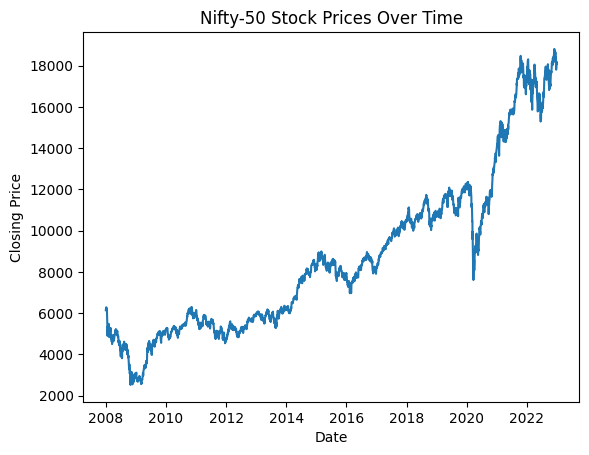

In [5]:
# Create a line plot of stock prices over time
plt.plot(stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Nifty-50 Stock Prices Over Time")
plt.show()

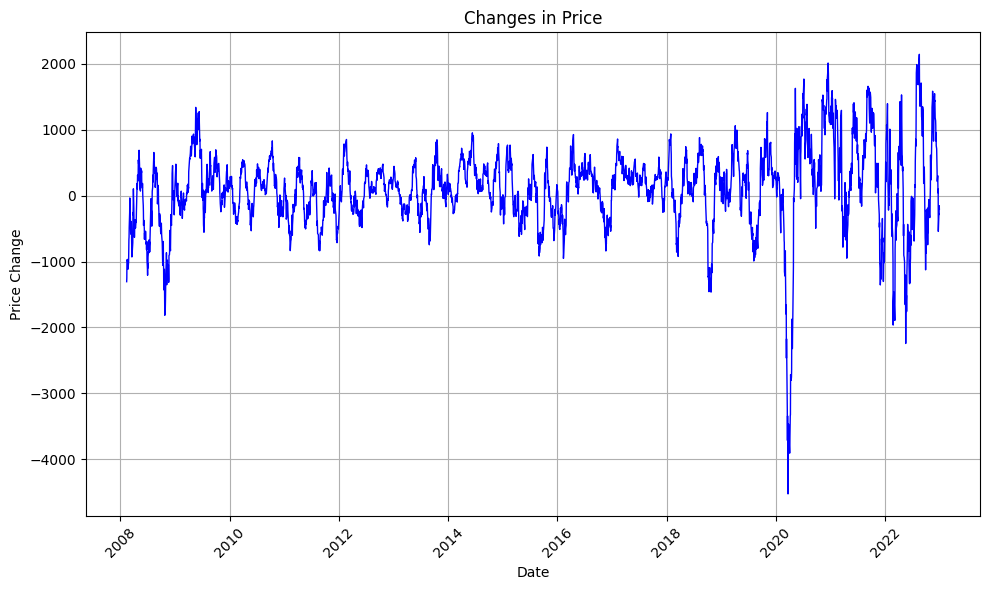

In [109]:

# Plot the every three week changes
plt.figure(figsize=(10, 6))

# Calculate the  difference in closing prices
price_diff = stock['Close'].diff(30)

# Plot the price difference
plt.plot(price_diff.dropna().index, price_diff.dropna(), color='blue', linestyle='-', linewidth=1)

# Set labels and title
plt.title('Changes in Price')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed


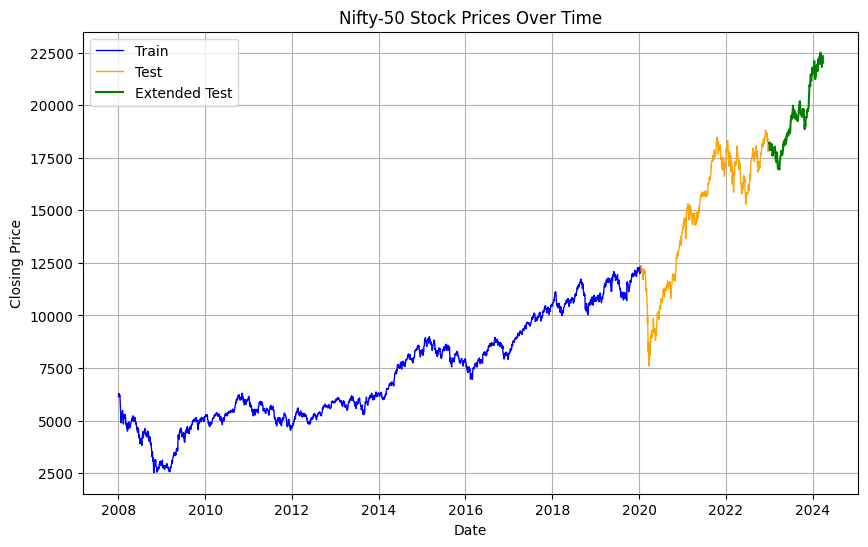

In [7]:
# Visualizing the train - test and extended test split (which is not part of original datset)
split_index = int(len(stock) * 0.8)
stock_ext = yf.download("^NSEI", start='2023-01-02', end='2024-04-01')

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(stock["Close"].iloc[:split_index], label='Train', color='blue', linewidth=1)
plt.plot(stock["Close"].iloc[split_index:], label='Test', color='orange', linewidth=1)
plt.plot(stock_ext["Close"], label='Extended Test', color='green')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Nifty-50 Stock Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()

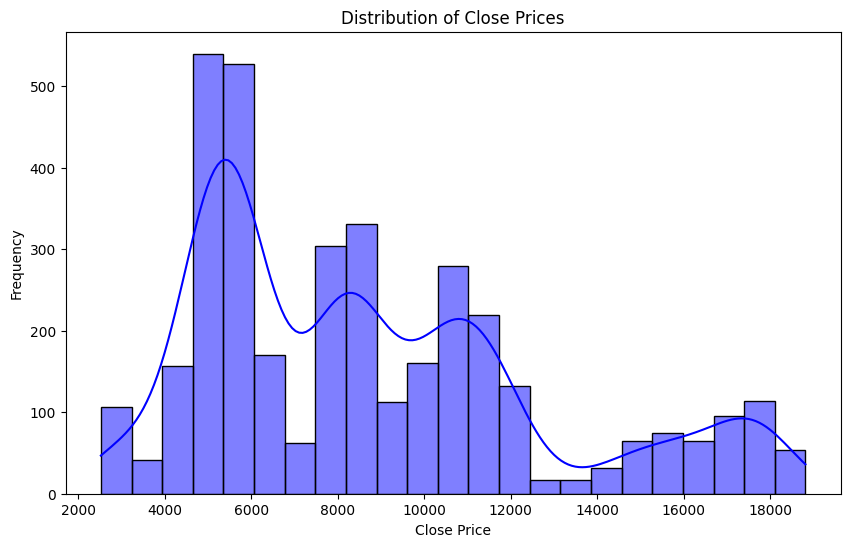

In [8]:
# Plotting the distribution of the 'Close' prices
plt.figure(figsize=(10, 6))
sns.histplot(stock['Close'], kde=True, color='blue')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

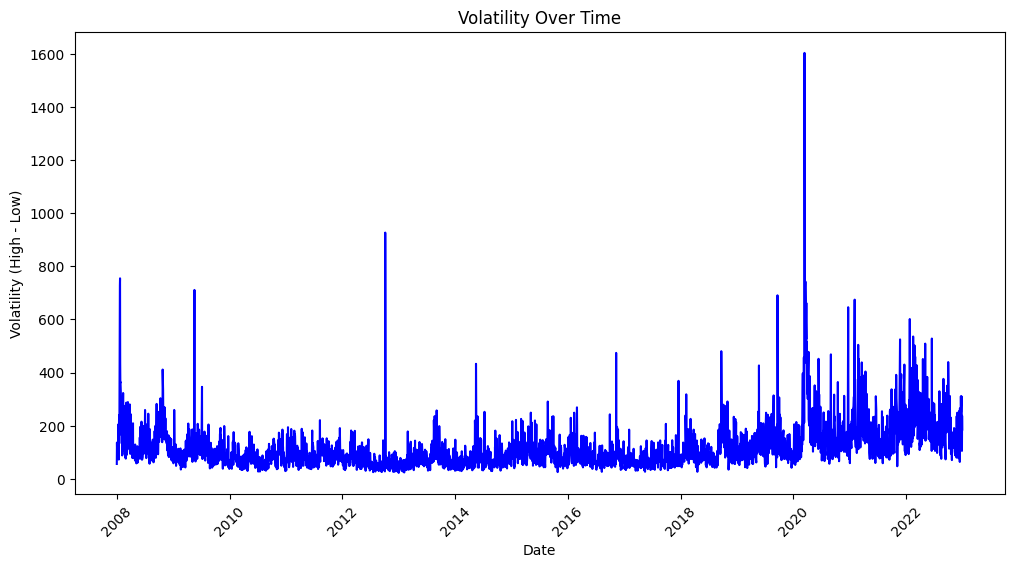

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(stock['High'] - stock['Low'], color='blue')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (High - Low)')
plt.xticks(rotation=45)
plt.show()

In [10]:
#Removing volumne column
stock.drop(['Volume'], axis=1, inplace=True)

<Axes: >

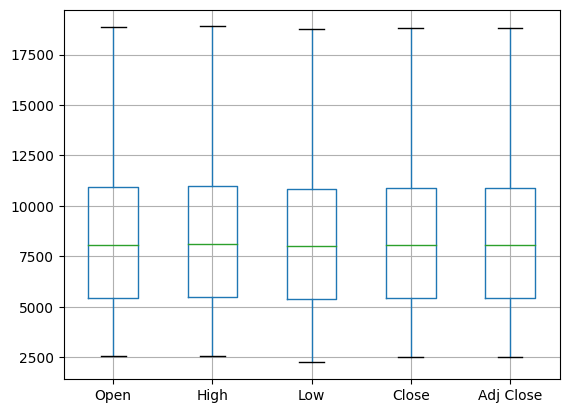

In [11]:
# Plotting the boxplot to identify the outliers
stock.boxplot()

In [12]:
#Function to evaluate the model
def model_evaluate(y_test,y_pred,model_name):
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"{model_name} - Mean Squared Error: {mse}")
  print(f"{model_name} - Mean Absolute Error: {mae}")
  print(f"{model_name} - R-squared: {r2}")
  print(f"{model_name} - Mean absolute percentage error: {mape}")

In [13]:
# Function to show the Autual vs Predicted graph
def show_graph(y_test,y_pred,model):
  y_pred = pd.DataFrame(y_pred)
  y_pred.index = y_test.index
  plt.plot(y_test, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title(f'{model} - Actual vs Predicted')
  plt.legend()
  plt.show()

In [14]:
# Function to create lag feature
def create_lag_and_target(data, lag_days, target_days):
    """
    Create lagged features and target for stock price prediction."""

    # Create lagged features
    for i in range(1, lag_days + 1):
        data[f'close_{i}'] = data['Close'].shift(i)

    # Create target for the specified future day
    data['Target'] = data['Close'].shift(-target_days)

    # Drop rows with NaN values introduced by lagging
    data = data.dropna()

    return data

In [15]:
#PCA to analyze the data
def pca(data,component):
  # Standardize the features (important for PCA)
  scaler = RobustScaler()
  scaled_features = scaler.fit_transform(data)

  # Initialize PCA with the desired number of components
  pca = PCA(n_components=component)

  # Fit PCA to the scaled features
  pca.fit(scaled_features)

  # Transform the original features to the PCA space
  pca_features = pca.transform(scaled_features)

  # Create a DataFrame to store the principal components
  pca_df = pd.DataFrame(data=pca_features, columns=[f'P_{i}' for i in range(1, component + 1)])

  print("Component explaining entire dataset - " + str(pca.explained_variance_ratio_))
  print("Variable extracted - " + str(pca.explained_variance_))
  return pca_df

In [16]:
# Assuming 'df' is your DataFrame with a 'Close' column
# and you want to create a lag of 40 days and predict the 50th day close price
data = create_lag_and_target(stock, lag_days=15, target_days=5)

In [17]:
data

,Open,High,Low,Close,Adj Close,close_1,close_2,close_3,close_4,close_5,...,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15,Target
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-22,5203.350098,5203.350098,4448.500000,4899.299805,4899.299805,5208.799805,5705.299805,5913.200195,5935.750000,6074.250000,...,6200.100098,6156.950195,6272.000000,6287.850098,6279.100098,6274.299805,6178.549805,6179.399902,6144.350098,5280.799805
2008-01-23,4903.049805,5328.049805,4891.600098,5203.399902,5203.399902,4899.299805,5208.799805,5705.299805,5913.200195,5935.750000,...,6206.799805,6200.100098,6156.950195,6272.000000,6287.850098,6279.100098,6274.299805,6178.549805,6179.399902,5167.600098
2008-01-24,5208.000000,5357.200195,4995.799805,5033.450195,5033.450195,5203.399902,4899.299805,5208.799805,5705.299805,5913.200195,...,6074.250000,6206.799805,6200.100098,6156.950195,6272.000000,6287.850098,6279.100098,6274.299805,6178.549805,5137.450195
2008-01-25,5035.049805,5399.250000,5035.049805,5383.350098,5383.350098,5033.450195,5203.399902,4899.299805,5208.799805,5705.299805,...,5935.750000,6074.250000,6206.799805,6200.100098,6156.950195,6272.000000,6287.850098,6279.100098,6274.299805,5317.250000
2008-01-28,5380.950195,5380.950195,5071.000000,5274.100098,5274.100098,5383.350098,5033.450195,5203.399902,4899.299805,5208.799805,...,5913.200195,5935.750000,6074.250000,6206.799805,6200.100098,6156.950195,6272.000000,6287.850098,6279.100098,5463.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,18288.099609,18431.650391,18244.550781,18420.449219,18420.449219,18269.000000,18414.900391,18660.300781,18608.000000,18497.150391,...,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18618.050781,18562.750000,18014.599609
2022-12-20,18340.300781,18404.900391,18202.650391,18385.300781,18385.300781,18420.449219,18269.000000,18414.900391,18660.300781,18608.000000,...,18496.599609,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18618.050781,18132.300781
2022-12-21,18435.150391,18473.349609,18162.750000,18199.099609,18199.099609,18385.300781,18420.449219,18269.000000,18414.900391,18660.300781,...,18497.150391,18496.599609,18609.349609,18560.500000,18642.750000,18701.050781,18696.099609,18812.500000,18758.349609,18122.500000


In [18]:
data.reset_index(drop=True, inplace=True)
# data.drop(['Date'],axis=1,inplace=True)

In [19]:
pca(data,4)

Component explaining entire dataset - [9.97682202e-01 1.48229139e-03 3.06830230e-04 1.54604068e-04]
Variable extracted - [1.09934624e+01 1.63333721e-02 3.38096299e-03 1.70358257e-03]


,P_1,P_2,P_3,P_4
0,-2.465609,0.403265,-0.187464,-0.056715
1,-2.484785,0.406642,-0.135888,-0.059042
2,-2.521069,0.416825,-0.083619,-0.060689
3,-2.535426,0.389943,0.005286,-0.086237
4,-2.559472,0.355883,0.076605,-0.085387
...,...,...,...,...
3650,8.233855,0.177642,-0.039819,0.044701
3651,8.229397,0.182184,-0.014334,0.034482
3652,8.209757,0.196686,-0.006309,0.039344
3653,8.168626,0.214288,-0.010030,0.011410


In [20]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
close_1      0
close_2      0
close_3      0
close_4      0
close_5      0
close_6      0
close_7      0
close_8      0
close_9      0
close_10     0
close_11     0
close_12     0
close_13     0
close_14     0
close_15     0
Target       0
dtype: int64

In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
# 'Close','Target','Open','High','Low','Adj Close'
feature_columns = data.drop(['Close','Target'],axis=1)
print(feature_columns.columns)

Index(['Open', 'High', 'Low', 'Adj Close', 'close_1', 'close_2', 'close_3',
       'close_4', 'close_5', 'close_6', 'close_7', 'close_8', 'close_9',
       'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15'],
      dtype='object')


In [23]:
y = data['Target']
X = data[feature_columns.columns] #

In [24]:
X.isnull().sum()

Open         0
High         0
Low          0
Adj Close    0
close_1      0
close_2      0
close_3      0
close_4      0
close_5      0
close_6      0
close_7      0
close_8      0
close_9      0
close_10     0
close_11     0
close_12     0
close_13     0
close_14     0
close_15     0
dtype: int64

In [25]:
y.isnull().sum()

0

In [26]:
split_index = int(len(X) * 0.8)

# Split the data
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

<Axes: >

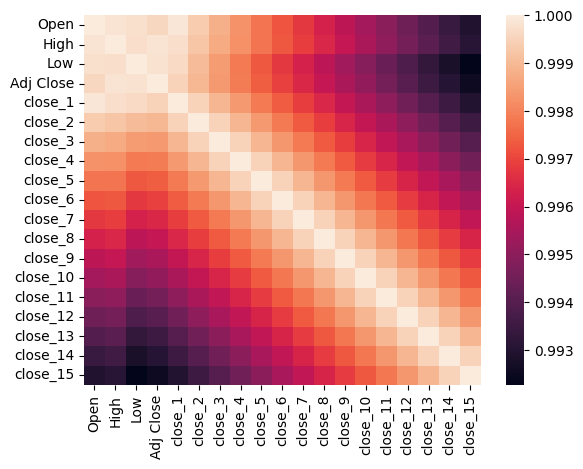

In [27]:
sns.heatmap(X_train.corr())

In [28]:
pca = PCA(n_components=4)

#Linear Regression

In [29]:
linear_reg_pipeline = Pipeline([
    # ('pca',pca),
    ('robust', RobustScaler()),
    ('MinMax', MinMaxScaler()),
    ('linear_reg', LinearRegression())
])

# Fit the pipeline on the training data
linear_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('robust', RobustScaler()), ('MinMax', MinMaxScaler()),
                ('linear_reg', LinearRegression())])

In [30]:
y_pred = linear_reg_pipeline.predict(X_test)

In [31]:
linear_reg_pipeline.score(X_test,y_test)

0.9808824886128887

In [32]:
model_evaluate(y_test,y_pred,'Linear Regression')

Linear Regression - Mean Squared Error: 161019.6951257346
Linear Regression - Mean Absolute Error: 302.2192010083748
Linear Regression - R-squared: 0.9808824886128887
Linear Regression - Mean absolute percentage error: 0.02192442957350478


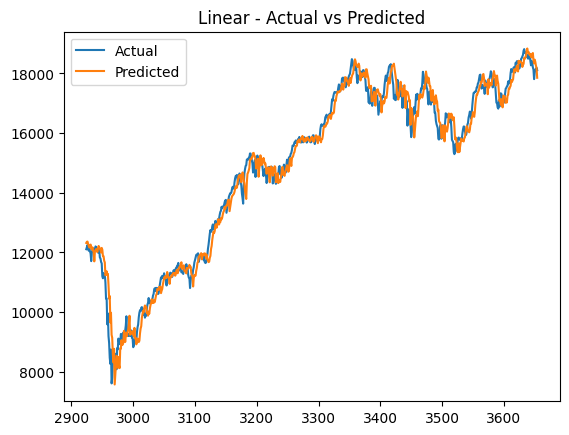

In [33]:
show_graph(y_test,y_pred,'Linear')

# Dataset for extended testing

[*********************100%%**********************]  1 of 1 completed


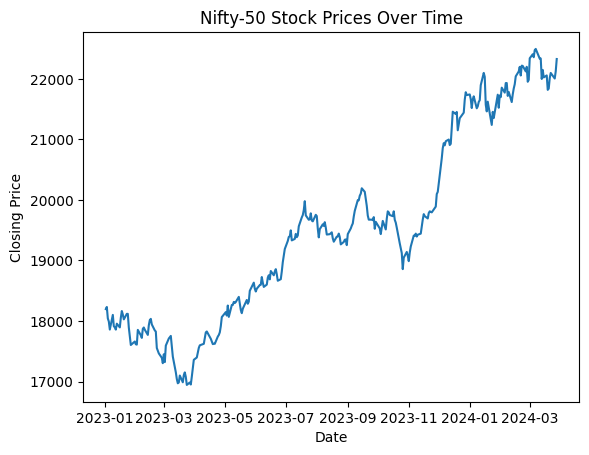

Index(['Open', 'High', 'Low', 'Adj Close', 'close_1', 'close_2', 'close_3',
       'close_4', 'close_5', 'close_6', 'close_7', 'close_8', 'close_9',
       'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15'],
      dtype='object')


In [34]:
## Real test

# Download the data from Yahoo Finance
test_stock = yf.download("^NSEI", start='2023-01-02', end='2024-04-01')

# Create a line plot of stock prices over time
plt.plot(test_stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Nifty-50 Stock Prices Over Time")
plt.show()

data_test = create_lag_and_target(test_stock, lag_days=15, target_days=5)
data_test.reset_index(drop=True, inplace=True)
feature_columns_test = data_test.drop(['Volume','Close','Target'],axis=1) # 'Close','Target','Open','High','Low','Adj Close'
print(feature_columns_test.columns)

y_real_test = data_test['Target']
X_Real_test = data_test[feature_columns_test.columns]

In [35]:
y_pred_T = linear_reg_pipeline.predict(X_Real_test)
linear_reg_pipeline.score(X_Real_test,y_real_test)

0.9610147724348174

In [36]:
model_evaluate(y_real_test,y_pred_T,'Linear Regression')

Linear Regression - Mean Squared Error: 94609.11581152146
Linear Regression - Mean Absolute Error: 242.75835410129858
Linear Regression - R-squared: 0.9610147724348174
Linear Regression - Mean absolute percentage error: 0.012418040633378405


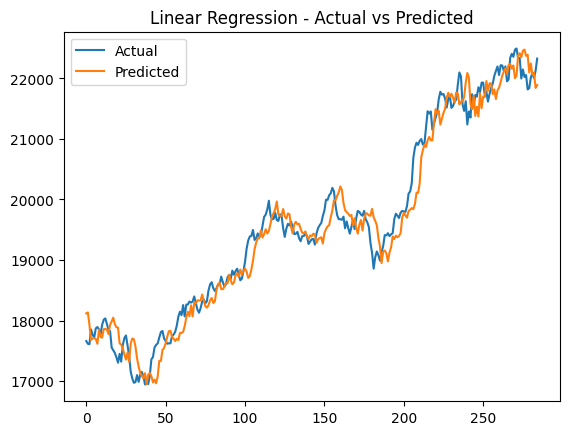

In [37]:
show_graph(y_real_test,y_pred_T,'Linear Regression')

In [38]:
# Creating final dataset
final_results = pd.concat([X_test, X_Real_test], ignore_index=False)

In [39]:
final_results

,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15
2924,12349.400391,12355.150391,12278.750000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12214.549805
2925,12347.099609,12389.049805,12315.799805,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805
2926,12328.400391,12385.450195,12321.400391,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805
2927,12430.500000,12430.500000,12216.900391,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609
2928,12195.299805,12230.049805,12162.299805,12169.849609,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781


In [40]:
#Create a DF for y_pred on test data and copy y_test index to y_pred
y_pred = pd.DataFrame(y_pred)
y_pred.index = y_test.index

#Same on extended test
y_pred_T = pd.DataFrame(y_pred_T)
y_pred_T.index = y_real_test.index

final_results['Target'] = pd.concat([pd.Series(y_test), pd.Series(y_real_test)],ignore_index=False)
final_results['Predicted_Linear'] = pd.concat([y_pred,y_pred_T],ignore_index=False)

In [41]:
final_results

,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,...,close_8,close_9,close_10,close_11,close_12,close_13,close_14,close_15,Target,Predicted_Linear
2924,12349.400391,12355.150391,12278.750000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,...,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12214.549805,12106.900391,12316.575229
2925,12347.099609,12389.049805,12315.799805,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,...,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12180.349609,12356.697142
2926,12328.400391,12385.450195,12321.400391,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,...,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12248.250000,12363.213628
2927,12430.500000,12430.500000,12216.900391,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,...,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12119.000000,12283.114060
2928,12195.299805,12230.049805,12162.299805,12169.849609,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,...,12215.900391,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12055.799805,12217.453363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,...,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781,22011.949219,22246.261664
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,...,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22096.750000,22057.165809
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,...,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22004.699219,22094.461585
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,...,22474.050781,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22123.650391,21843.275382


In [42]:
time_split = TimeSeriesSplit(n_splits=3)

In [43]:
# Create a pipeline with PolynomialFeatures
pipeline = Pipeline([
    ('pca',pca),
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('linear_reg', LinearRegression())
])

# # Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [2,3,4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid,cv=time_split,scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best degree from the grid search
best_degree = grid_search.best_params_['poly_features__degree']

# Plot the data and the polynomial regression curve
y_pred = grid_search.predict(X_test)

In [44]:
print("Best Degree " + str(best_degree))
print(-grid_search.cv_results_['mean_test_score'])

Best Degree 2
[  37171.8776953   272213.98492935 2785205.69221304]


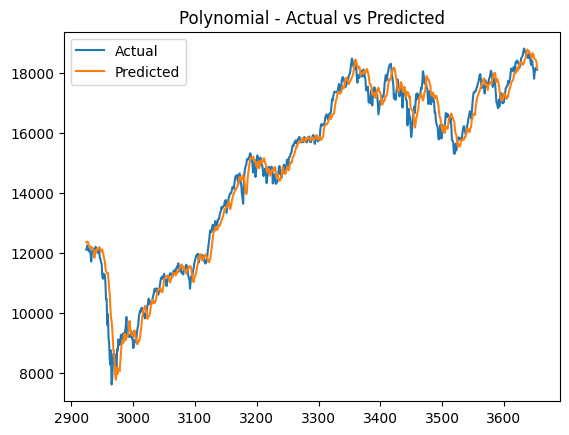

In [45]:
show_graph(y_test,y_pred,'Polynomial')

In [ ]:
model_evaluate(y_test,y_pred,'Polynomial regression')

Polynomial regression - Mean Squared Error: 184665.4604544055
Polynomial regression - Mean Absolute Error: 320.69908670504714
Polynomial regression - R-squared: 0.9780750793231442
Polynomial regression - Mean absolute percentage error: 0.023398310542511652


In [46]:
y_pred_T = grid_search.predict(X_Real_test)
grid_search.score(X_Real_test,y_real_test)

-106919.38590734638

In [47]:
model_evaluate(y_real_test,y_pred_T,'Polynomial Regression')

Polynomial Regression - Mean Squared Error: 106919.38590734638
Polynomial Regression - Mean Absolute Error: 258.6065531306853
Polynomial Regression - R-squared: 0.9559421250798766
Polynomial Regression - Mean absolute percentage error: 0.013229116553173114


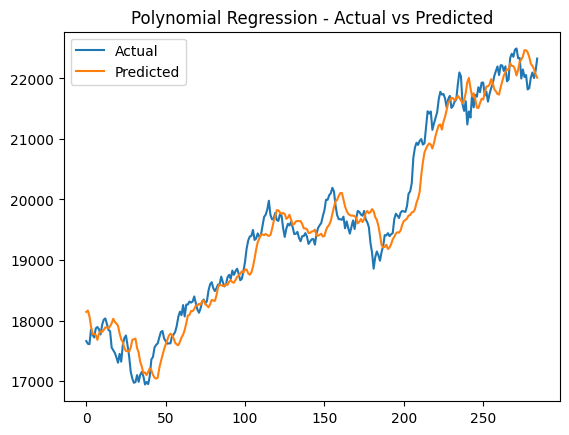

In [48]:
show_graph(y_real_test,y_pred_T,'Polynomial Regression')

In [49]:
#Create a DF for y_pred on test data and copy y_test index to y_pred
y_pred = pd.DataFrame(y_pred)
y_pred.index = y_test.index

#Same on extended test
y_pred_T = pd.DataFrame(y_pred_T)
y_pred_T.index = y_real_test.index

final_results['Predicted_Polynomial'] = pd.concat([y_pred,y_pred_T],ignore_index=False)

In [50]:
final_results

,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,...,close_9,close_10,close_11,close_12,close_13,close_14,close_15,Target,Predicted_Linear,Predicted_Polynomial
2924,12349.400391,12355.150391,12278.750000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,...,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12214.549805,12106.900391,12316.575229,12350.209849
2925,12347.099609,12389.049805,12315.799805,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,...,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12180.349609,12356.697142,12370.303386
2926,12328.400391,12385.450195,12321.400391,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,...,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12248.250000,12363.213628,12367.620707
2927,12430.500000,12430.500000,12216.900391,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,...,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12119.000000,12283.114060,12349.772150
2928,12195.299805,12230.049805,12162.299805,12169.849609,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,...,12025.349609,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12055.799805,12217.453363,12244.824427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,...,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781,22011.949219,22246.261664,22242.696363
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,...,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22096.750000,22057.165809,22204.510555
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,...,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22004.699219,22094.461585,22153.685170
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,...,22356.300781,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22123.650391,21843.275382,22065.744452


In [51]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Elastic Net Regression
elastic_net_pipeline = Pipeline([
    ('pca',pca),
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('elastic_net_reg', ElasticNet())
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [2, 3],
    'elastic_net_reg__alpha': np.logspace(-4, 2, 7),  # Adjust the range as needed
    'elastic_net_reg__l1_ratio': [0,0.1,0.3, 0.5,0.7, 0.9,1]  # Adjust the ratios as needed
}

scoring = ['neg_mean_squared_error', 'accuracy']

# Create the GridSearchCV object
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid,scoring='neg_mean_squared_error', cv=time_split, return_train_score=True)

# Perform the grid search
elastic_net_grid_search.fit(X_train, y_train)

# Get the best degree, alpha, and l1_ratio from the grid search
best_degree = elastic_net_grid_search.best_params_['poly_features__degree']
best_alpha = elastic_net_grid_search.best_params_['elastic_net_reg__alpha']
best_l1_ratio = elastic_net_grid_search.best_params_['elastic_net_reg__l1_ratio']

print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")
print(f"Best L Ratio - {best_l1_ratio}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+07, tolerance: 6.730e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e+07, tolerance: 1.094e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best Degree - 2
Best Alpha - 0.1
Best L Ratio - 1


In [52]:
y_pred = elastic_net_grid_search.predict(X_test)

In [53]:
model_evaluate(y_test,y_pred,'ElasticNet regression')

ElasticNet regression - Mean Squared Error: 174249.1372339262
ElasticNet regression - Mean Absolute Error: 314.4595244272189
ElasticNet regression - R-squared: 0.979311786283891
ElasticNet regression - Mean absolute percentage error: 0.02281551684198785


In [54]:
y_pred_T = grid_search.predict(X_Real_test)
grid_search.score(X_Real_test,y_real_test)

-106919.38590734638

In [55]:
model_evaluate(y_real_test,y_pred_T,'ElasticNet Regression')

ElasticNet Regression - Mean Squared Error: 106919.38590734638
ElasticNet Regression - Mean Absolute Error: 258.6065531306853
ElasticNet Regression - R-squared: 0.9559421250798766
ElasticNet Regression - Mean absolute percentage error: 0.013229116553173114


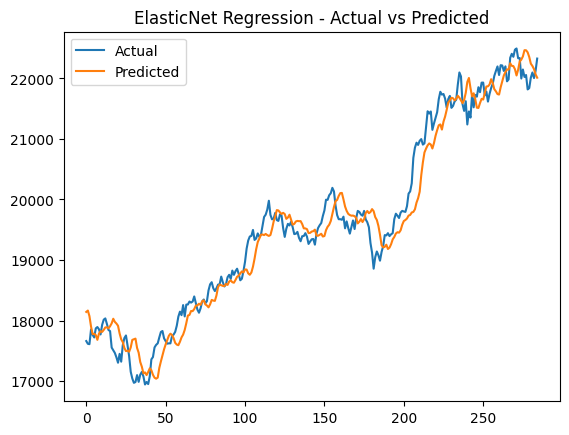

In [56]:
show_graph(y_real_test,y_pred_T,'ElasticNet Regression')

In [57]:
#Create a DF for y_pred on test data and copy y_test index to y_pred
y_pred = pd.DataFrame(y_pred)
y_pred.index = y_test.index

#Same on extended test
y_pred_T = pd.DataFrame(y_pred_T)
y_pred_T.index = y_real_test.index

final_results['Predicted_ElasticNet'] = pd.concat([y_pred,y_pred_T],ignore_index=False)

In [58]:
final_results

,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,...,close_10,close_11,close_12,close_13,close_14,close_15,Target,Predicted_Linear,Predicted_Polynomial,Predicted_ElasticNet
2924,12349.400391,12355.150391,12278.750000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,...,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12214.549805,12106.900391,12316.575229,12350.209849,12351.877484
2925,12347.099609,12389.049805,12315.799805,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,...,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12180.349609,12356.697142,12370.303386,12369.302786
2926,12328.400391,12385.450195,12321.400391,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,...,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12248.250000,12363.213628,12367.620707,12361.476684
2927,12430.500000,12430.500000,12216.900391,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,...,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12119.000000,12283.114060,12349.772150,12339.081838
2928,12195.299805,12230.049805,12162.299805,12169.849609,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,...,12052.950195,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12055.799805,12217.453363,12244.824427,12228.535425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,...,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781,22011.949219,22246.261664,22242.696363,22242.696363
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,...,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22096.750000,22057.165809,22204.510555,22204.510555
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,...,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22004.699219,22094.461585,22153.685170,22153.685170
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,...,22405.599609,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22123.650391,21843.275382,22065.744452,22065.744452


In [59]:
final_results['is_extended_test'] = 'N'
final_results.loc[final_results.index.isin(y_pred_T.index), 'is_extended_test'] = 'Y'

In [60]:
final_results

,Open,High,Low,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,...,close_11,close_12,close_13,close_14,close_15,Target,Predicted_Linear,Predicted_Polynomial,Predicted_ElasticNet,is_extended_test
2924,12349.400391,12355.150391,12278.750000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,12052.950195,...,12168.450195,12255.849609,12245.799805,12126.549805,12214.549805,12106.900391,12316.575229,12350.209849,12351.877484,N
2925,12347.099609,12389.049805,12315.799805,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,12025.349609,...,12182.500000,12168.450195,12255.849609,12245.799805,12126.549805,12180.349609,12356.697142,12370.303386,12369.302786,N
2926,12328.400391,12385.450195,12321.400391,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,12215.900391,...,12282.200195,12182.500000,12168.450195,12255.849609,12245.799805,12248.250000,12363.213628,12367.620707,12361.476684,N
2927,12430.500000,12430.500000,12216.900391,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,12256.799805,...,12226.650391,12282.200195,12182.500000,12168.450195,12255.849609,12119.000000,12283.114060,12349.772150,12339.081838,N
2928,12195.299805,12230.049805,12162.299805,12169.849609,12224.549805,12352.349609,12355.500000,12343.299805,12362.299805,12329.549805,...,11993.049805,12226.650391,12282.200195,12182.500000,12168.450195,12055.799805,12217.453363,12244.824427,12228.535425,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,21982.550781,22204.599609,21917.500000,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,22356.300781,...,22198.349609,22122.050781,22212.699219,22217.449219,22055.050781,22011.949219,22246.261664,22242.696363,22242.696363,Y
281,22064.849609,22120.900391,21931.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,22474.050781,...,21951.150391,22198.349609,22122.050781,22212.699219,22217.449219,22096.750000,22057.165809,22204.510555,22204.510555,Y
282,21990.099609,22123.699219,21916.550781,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,22493.550781,...,21982.800781,21951.150391,22198.349609,22122.050781,22212.699219,22004.699219,22094.461585,22153.685170,22153.685170,Y
283,21946.449219,21978.300781,21793.099609,21817.449219,22055.699219,22023.349609,22146.650391,21997.699219,22335.699219,22332.650391,...,22338.750000,21982.800781,21951.150391,22198.349609,22122.050781,22123.650391,21843.275382,22065.744452,22065.744452,Y


In [61]:
stock_prediction_plot = yf.download("^NSEI", start='2018-01-01', end='2024-04-01')

[*********************100%%**********************]  1 of 1 completed


In [62]:
stock_prediction_plot.reset_index(inplace=True)

In [63]:
stock_prediction_plot.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [64]:
final_results.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'close_1', 'close_2', 'close_3',
       'close_4', 'close_5', 'close_6', 'close_7', 'close_8', 'close_9',
       'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15',
       'Target', 'Predicted_Linear', 'Predicted_Polynomial',
       'Predicted_ElasticNet', 'is_extended_test'],
      dtype='object')

In [65]:
final = final_results.merge(stock_prediction_plot, on=["Open", "High", "Low"], how="inner")

In [66]:
final_plot = final[['Date','Target','Predicted_Linear','Predicted_Polynomial','Predicted_ElasticNet','is_extended_test']]

In [67]:
final_plot.set_index('Date',inplace=True)

In [68]:
final_plot

,Target,Predicted_Linear,Predicted_Polynomial,Predicted_ElasticNet,is_extended_test
Date,,,,,
2020-01-15,12106.900391,12316.575229,12350.209849,12351.877484,N
2020-01-16,12180.349609,12356.697142,12370.303386,12369.302786,N
2020-01-17,12248.250000,12363.213628,12367.620707,12361.476684,N
2020-01-20,12119.000000,12283.114060,12349.772150,12339.081838,N
2020-01-21,12055.799805,12217.453363,12244.824427,12228.535425,N
...,...,...,...,...,...
2024-03-14,22011.949219,22246.261664,22242.696363,22242.696363,Y
2024-03-15,22096.750000,22057.165809,22204.510555,22204.510555,Y
2024-03-18,22004.699219,22094.461585,22153.685170,22153.685170,Y


from matplotlib import pyplot as plt
final_plot['Target'].plot(kind='hist', bins=20, title='Target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_Linear'].plot(kind='hist', bins=20, title='Predicted_Linear')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_Polynomial'].plot(kind='hist', bins=20, title='Predicted_Polynomial')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_ElasticNet'].plot(kind='hist', bins=20, title='Predicted_ElasticNet')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_plot.groupby('is_extended_test').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot.plot(kind='scatter', x='Target', y='Predicted_Linear', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot.plot(kind='scatter', x='Predicted_Linear', y='Predicted_Polynomial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot.plot(kind='scatter', x='Predicted_Polynomial', y='Predicted_ElasticNet', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Target'].plot(kind='line', figsize=(8, 4), title='Target')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_Linear'].plot(kind='line', figsize=(8, 4), title='Predicted_Linear')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_Polynomial'].plot(kind='line', figsize=(8, 4), title='Predicted_Polynomial')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_plot['Predicted_ElasticNet'].plot(kind='line', figsize=(8, 4), title='Predicted_ElasticNet')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_plot['is_extended_test'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_plot, x='Target', y='is_extended_test', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_plot['is_extended_test'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_plot, x='Predicted_Linear', y='is_extended_test', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_plot['is_extended_test'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_plot, x='Predicted_Polynomial', y='is_extended_test', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_plot['is_extended_test'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_plot, x='Predicted_ElasticNet', y='is_extended_test', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Figure size 1000x600 with 0 Axes>

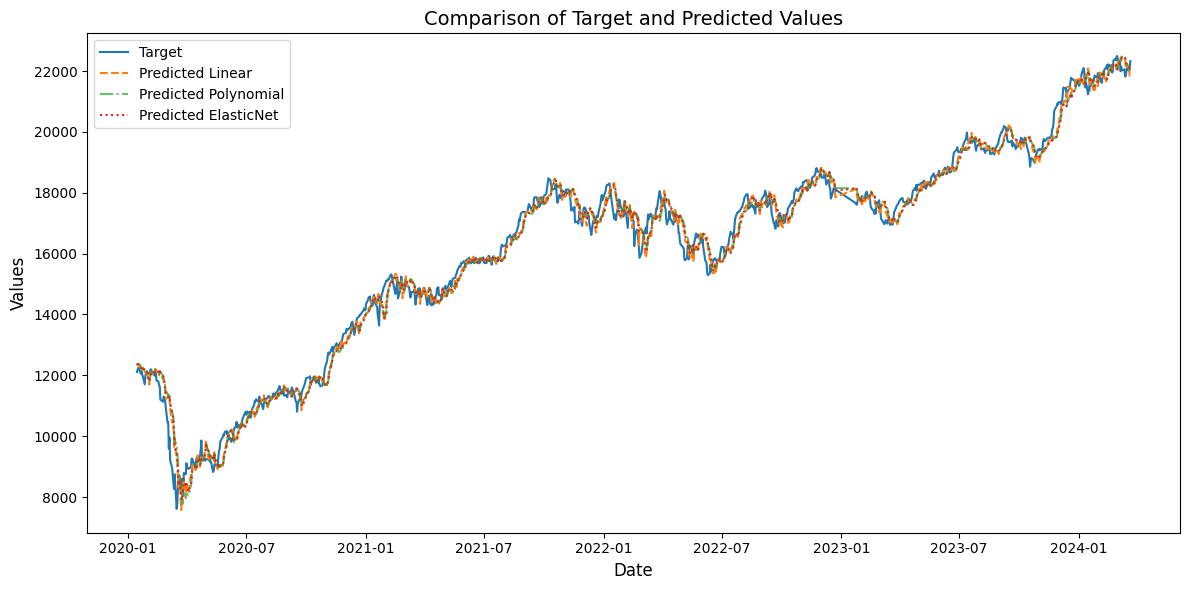

In [95]:
data = final_plot.copy().reset_index()

plt.figure(figsize=(10, 6))

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Target'], label='Target')
plt.plot(data['Date'], data['Predicted_Linear'], label='Predicted Linear', linestyle='--')
plt.plot(data['Date'], data['Predicted_Polynomial'], label='Predicted Polynomial', linestyle='-.',alpha=0.7)
plt.plot(data['Date'], data['Predicted_ElasticNet'], label='Predicted ElasticNet', markersize=3, linestyle=':')

# Set labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Comparison of Target and Predicted Values', fontsize=14)

# Customize the legend
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
